# Statistical Pattern Recognition: Assignment 3
**Title**    : mixture models and EM Algorithm

**Members**  : Jayanth S, Praveen Kumar N, Rishabh Roy

# **Problem 2:**


## **Univariate gaussian mixture model:**

## **Multivariate gaussian mixture model:**

In [ ]:
!pip install plotly

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
from itertools import product, combinations
import os
import scipy.stats as stat
from sklearn.metrics import confusion_matrix
from sklearn.mixture import GMM
import seaborn as sns
import pandas as pd
import cv2
import sklearn
import sklearn.datasets as dataset
from sklearn.mixture import GaussianMixture
from scipy.stats import multivariate_normal
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import plotly.express as px

In [ ]:
def gmm_algorithm_mulivariate(iterations,P_em,K,clas):

    """GMM ALGORITHM
    Input : 
    iterations -- Maximum no. of iterations
    P_em       -- dictionary that contains parameters and weightages of all mixture components
    K          -- no. of mixture components
    
    Return: 
    P_em -- Updated dictionary that contains parameters and weightages of all mixture components
    res_coeff  -- contains the responsibility coefficient of all images w.r.t each mixture
    log_likey  -- contains log likelihood of each iteration
    
    """
    
    
    ll_old=0
    ll_new=0
    log_likely= np.zeros((iterations,1))
    d=clas.shape[1]
    N=clas.shape[0]
    
    for itr in range(iterations):  
        #responsibility coefficient of size(no. of samples in clas x mixture components)
        res_coeff=np.zeros((len(clas),K))  
        
        for n in range(len(clas)):
            res_coeff_nr=np.zeros((1,K))       #to store respob. coeff of each mixture component
            xn=clas[n][:]
            xn=np.reshape(xn,(d,1))
            #print(xn.shape)
            for k in range(K):
                
                mu=P_em["mean"+str(k)]  #stores the mean of kth component
                mu=np.reshape(mu,(d,1))
                var=P_em["variance"+str(k)]
                var=np.abs(var)
                #below code is to find Gaussian(x_n,theta_k)

                var_inv=np.linalg.inv(var+np.identity(d)*0.01)
                fx_pi=(1/np.sqrt((2*np.pi)))**(d)
                fx_var=np.abs(np.linalg.det(var))
                
                fx_var=np.abs(1/np.sqrt(fx_var))
                muSmu=((xn-mu).T@var_inv@(xn-mu))*0.5
                
                
                f_x_k=fx_pi*fx_var*np.exp(-muSmu)
                
                #update the responsibility coefficient for kth component
                res_coeff_nr[0,k]=P_em["lamda"][k]*f_x_k
                #print(f"value of res : {res_coeff_nr[0,:]}, {itr}")
           

            # respob. coeff of nth sample with kth mixture
            #added 1e-50 to the denominator so that responsibility coefficient doesn't become undefined value (0/0 form)
            res_coeff[n,:]=res_coeff_nr[0,:]/(np.sum(res_coeff_nr)+1e-50) 
            

        #EXPECTATION - STEP    
        N_k=np.sum(res_coeff,axis=0) 
        #print(np.sum(N_k))
        #update the lamda parameter for all mixture components
        P_em["lamda"]=N_k/N #len(clas)
        #P_em["lamda"]=P_em["lamda"]/np.sum(P_em["lamda"])
        #print(np.sum(P_em["lamda"]))
    
        #print(f"Value of {np.sum(N_k)},{itr}")
        #below code is to update the mean and variances for the mixture components
        #xi=clas   
        for k in range(K):
            mean_temp=np.zeros((d,1))
            #var_temp=np.zeros((d,d))
            for n in range(len(clas)):
                xi=clas[n,:]
                xi=np.reshape(xi,(d,1))

                res_coeff_k=res_coeff[n,k]
                #res_coeff_k=np.reshape(res_coeff_k,(1,len(clas)))

                #MAXIMISATION - STEP
                #added 1e-50 to the denominator so that responsibility coefficient doesn't become undefined value (0/0 form)
                temp_mu=P_em["mean"+str(k)]
                temp_mu=np.reshape(temp_mu,(d,1))
                xi_mu=xi-temp_mu
                sigma=np.outer(xi_mu,xi_mu)
#                 print(f"xi_mu {np.shape(xi_mu)}")
#                 print(f"sigma {np.shape(sigma)}")
#                 var_temp=np.linalg.inv(sigma)
#                 print(np.shape(var_temp),np.shape(res_coeff_k))
                mean_temp= mean_temp+(res_coeff_k*xi)
                #var_temp= var_temp+np.abs((res_coeff_k*(sigma)))
            
            #update the mean and variances of kth class
            
            P_em["mean"+str(k)]= mean_temp/(N_k[k]+1e-50)
            for k in range(K):
              #mean_temp=np.zeros((d,1))
              var_temp=np.zeros((d,d))
              for n in range(len(clas)):
                  xi=clas[n,:]
                  xi=np.reshape(xi,(d,1))

                  res_coeff_k=res_coeff[n,k]
                  #res_coeff_k=np.reshape(res_coeff_k,(1,len(clas)))

                  #MAXIMISATION - STEP
                  #added 1e-50 to the denominator so that responsibility coefficient doesn't become undefined value (0/0 form)
                  temp_mu=P_em["mean"+str(k)]
                  temp_mu=np.reshape(temp_mu,(d,1))
                  xi_mu=xi-temp_mu
                  sigma=np.outer(xi_mu,xi_mu)
  #                 print(f"xi_mu {np.shape(xi_mu)}")
  #                 print(f"sigma {np.shape(sigma)}")
  #                 var_temp=np.linalg.inv(sigma)
  #                 print(np.shape(var_temp),np.shape(res_coeff_k))
                  #mean_temp= mean_temp+(res_coeff_k*xi)
                  var_temp= var_temp+np.abs((res_coeff_k*(sigma)))
            
              P_em["variance"+str(k)]= np.abs(var_temp)/(N_k[k]+1e-50)
            
     


        """Below code is find the log likelihood for the parameters obtained in the current iteration"""
        ll=0
        for n in range(len(clas)):
            x=clas[n][:]
            x=np.reshape(x,(d,1))
            for k in range(K):
                
                mu=P_em["mean"+str(k)]  #stores the mean of kth component
                mu=np.reshape(mu,(d,1))
                var=np.abs(P_em["variance"+str(k)])
               
                var_inv=np.abs(np.linalg.inv(var+np.identity(d)*1e-5)) #to avoid singularity
                fx_pi=(1/np.sqrt((2*np.pi)))**(d)
                fx_var=np.abs(1/(np.linalg.det(var+np.identity(d)*1e-5)))
                #fx_var=np.sqrt(fx_var)
                muSmu=((x-mu).T@var_inv@(x-mu))*0.5
                
                
                f_x_k=np.log(fx_pi)+0.5*np.log(fx_var)-muSmu
                
                ll_update=res_coeff[n,k]*(f_x_k+np.log(P_em["lamda"][k]+0.01)) #(xi@p_i.T+(1-xi)@(p_i_minus).T
                ll=ll+ll_update
                
        ll_old=ll_new
        ll_new=ll
#       print(f"log likelihood : {ll_new},old : {ll_old}")

        log_likely[itr]=ll_new


        
#         if (abs(ll_new-ll_old)<1 and itr>=1):
#             #log_likely[itr+1:iterations]=log_likely[itr]
#             print(f"For iteration {itr} the difference between new log likelihood and old log likelihood is less than 1")
#             break
    
    return log_likely,P_em,res_coeff,itr



In [ ]:
def k_means_init(K,iteration_max,samples):
    iterations=iteration_max   #no. of iterations
    K=K
    z=np.random.randint(0,K,size=(samples.shape[0],1))
    tot_err=np.zeros((iterations,1))
    d=samples.shape[1]   #dimesnion of the data
    N=samples.shape[0]   #size of the data
    
    for itr in range(iterations):
        total_err=0
        mu=np.zeros((K,d))
       

        #print(np.shape(covariance))
        xi_s=samples            
        xi_s=np.array(xi_s)

        #print(np.shape(xi_s))
        err=np.zeros((K,1))
        for k in range(K):
            mean_temp=np.zeros((1,d))
            var_temp=np.zeros((d,d))

            zd=np.where(z==k,1,0)
            for n in range(N):

                #find the mean value of kth mixture component using the samples that belong to the kth mixture in ith class
                mean_temp=mean_temp+(zd[n]*xi_s[n,:])
                mean_temp=np.reshape(mean_temp,(1,d))
    #             x_mu=xi_s[n,:]-mu[k,:]
    #             #print(x_mu.shape)
    #             var_temp=(x_mu@x_mu.T)
    #             #var_temp=var_temp.reshape(2,600,2,600).sum(axis=(1,3))
    #             var_temp=var_temp+z_d[n]*var_temp
    #             #var_temp

            #print(np.sum(z_d),k)
            #update the mean values
            mu[k,:]=mean_temp/(np.sum(zd))    
            covariance=np.zeros((K,d,d))

            #below code is to find the covaraince and total erro
            for n in range(N):
                x_mu=xi_s[n,:]-mu[k,:]
                x_mu=np.reshape(x_mu,(d,1))
                var_temp=np.abs(zd[n]*x_mu@x_mu.T)
                #var_temp=var_temp.reshape(2,600,2,600).sum(axis=(1,3))
                var_temp=var_temp+var_temp
                #var_temp
            covariance[k][:,:]=var_temp/np.sum(zd)


            error=zd.T@(xi_s-mu[k,:])
            err[k]=err[k]+np.linalg.norm(error)

        #total error for each iteration
        tot_err[itr]=np.sum(err)

        #below code is to re-assignments of samples to different bins(mixture components)
        n=0   
        for n in range(len(xi_s)):
            xn=xi_s[n][:]-mu
            #print(np.shape(xn))
            min_dist=np.linalg.norm(xn,axis=1)

            z[n]=np.argmin(min_dist)  #store the distance  that is minimum among all the mixture components 

        #print(min_dist)

        z[n]=np.argmin(min_dist)
        #print(min_dist)



        if total_err<1e-20:
          #print(f"The iteration no. at which the total_err is less than 1e-20 is {total_err}: corresponding iteration is {itr}")
          break
    return mu,covariance

In [ ]:
K =3     # Number of mixture components in univariate GMM 
N = 200 # Number of samples to be drawn from each mixture of mulitvariate Gaussian to construct the mixture density 
iterations=10
d=4     #dimenion of the data
mean=np.zeros((K,d))
  
covariance=[]


#"""Below code is to generate the mean vector and covariance matrix for the mixture components"""
#mean[0,:]= 0
# covariance_temp= np.ones((d,d))*5
# covariance.append(covariance_temp) #np.linspace(3,6, num=K)
samples=[] 
#samples_temp=np.random.multivariate_normal(mean[0,:],covariance_temp,200)
#samples=np.array(samples_temp)
for k in range(K):
    mean[k,:]= -20+40*np.random.rand(1,d)
    covariance_temp= sklearn.datasets.make_spd_matrix(d)
    covariance_temp= np.identity(d)*(k+1) #np.abs(covariance_temp@covariance_temp.T)
    covariance.append(covariance_temp) #np.linspace(3,6, num=K)
    samples_temp=np.random.multivariate_normal(mean[k,:],covariance_temp,N*(k+1))
    samples=np.append(samples,samples_temp)  
    print(covariance_temp) 

true_covar=covariance
samples=np.array(samples)
samples=np.reshape(samples,(6*N,d))


#print(samples[750:799,:])
#print(np.shape(samples),np.shape(covariance[2]),np.shape(mean))
    #lambdas   = [0.5,0.5,0.5]

# samples_lst = [np.random.normal(loc = means[k],scale = np.sqrt(variances[k]),size = int(2500)) for k in range(K)]
# samples     = np.expand_dims(np.array([item for sublist in samples_lst for item in sublist]),axis=1)
# sns.displot(samples, color='b')
# plt.hist(samples, bins =10,density=True)
# plt.show()

P_init={}
#random initialisation of parameters
pi=np.ones((1,K))*(1/K)  #np.random.dirichlet(alpha)  #to genereate lamda values such that they sum to 1
P_init["lamda"]=np.array([0.1,0.85,0.05])       #pi[0,:]

#means,covariance_k= k_means_init(K,2,samples)
#print(covariance_k)
for k in range(K):
    P_init["mean"+str(k)]=8*np.random.rand(1,d) # means[k,:] #
    P_init["variance"+str(k)]=np.identity(d)#covariance_k[k][:,:] 

# print(samples.shape)
# print(means.shape)
#print(covariance)
log_likely,P,res_coeff,itera=gmm_algorithm_mulivariate(iterations,P_init,K,samples)
plt.figure(figsize=(10,10))
plt.title("Log Likelihood")
#plt.axis('off')

plt.plot(log_likely)#plt.plot(np.linspace(1,iter_convg,iter_convg),log_likehood[:iter_convg])  #np.linspace(1,iterations,iterations),
plt.xlabel("iteration")
plt.ylabel("log likelihood")
plt.show()

# print(mean)
# print(covariance)

for i in range(K):
    print(f"For component {i}  true mean is {mean[i]}: and covariance is {covariance[i]}")

for i in range(K):
    print(f"For some component mean is : ",end='')
    print(np.squeeze(P["mean"+str(i)]),end=' , variance is : ')
    print(np.squeeze(P["variance"+str(i)]),end=' and the weight is : ')
    print(np.squeeze(P["lamda"][i]))





### Parzen window for Univariate Gaussian Mixture Model





In [ ]:
def rectangular(sample_test,samples,h):

  d=samples.shape[1]  #dimension of the samples
  k=0
  N=samples.shape[0]  #total no. of samples
  for x in samples:
    if np.linalg.norm(sample_test-x)<h/2:    #sample_test : The point at which the density needs to be estimated
      k=k+1
  parzen_est=k/(N*(h**d))      #this is the parzen window estimate using rectangular window
  return parzen_est




In [ ]:
def gaussian(sample_test,samples,h):

  d=samples.shape[1]  #dimension of the samples

  k=0
  N=samples.shape[0] #total no. of samples
  f_x=0
  for x in samples:   #sample_test : The point at which the density needs to be estimated
    f_xi=np.exp(-(np.linalg.norm(sample_test-x)/(2*(h**2))))    #estimate the density at sample_test using gaussian density function as the kernel function 
    f_x=f_x+f_xi
  f_x=((1/np.sqrt(2*np.pi))**d)*(1/(N*(h**d)))*f_x   #this is the parzen window estimate using gaussian window
  return f_x



<Figure size 720x720 with 0 Axes>

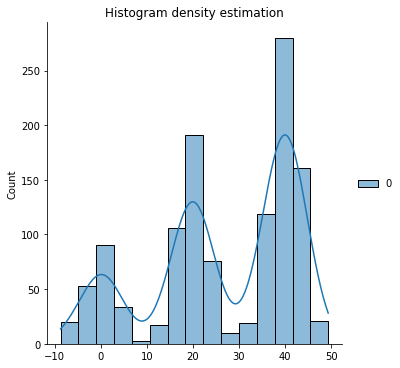

Density estimation using Kernel fuctions being rectangular window


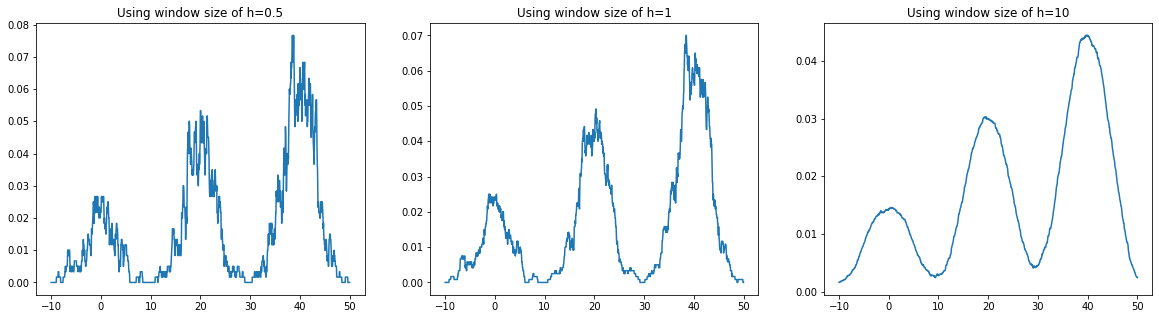

Density estimation using Kernel fuctions being gaussian window


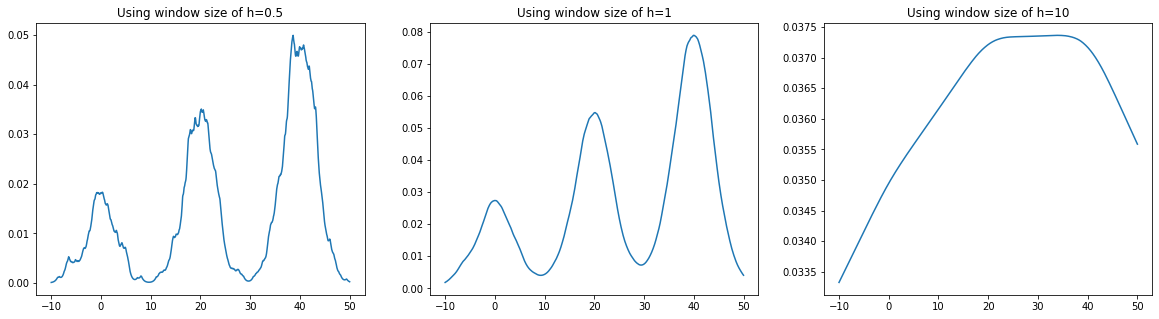

In [ ]:
K = 3     # Number of mixture components in univariate GMM 
N = 200 # Number of samples to be drawn from each mixture of mulitvariate Gaussian to construct the mixture density 
iterations=10
d=1     #dimenion of the data
mean=np.zeros((K,d))
  
covariance=[]


#"""Below code is to generate the mean vector and covariance matrix for the mixture components"""
#mean[0,:]= 0
# covariance_temp= np.ones((d,d))*5
# covariance.append(covariance_temp) #np.linspace(3,6, num=K)
samples=[] 
#samples_temp=np.random.multivariate_normal(mean[0,:],covariance_temp,200)
#samples=np.array(samples_temp)

#below code is to generate samples using which density estimation is done
for k in range(K):
    mean[k,:]= k*20#-20+80*np.random.rand(1,d)
    covariance_temp= sklearn.datasets.make_spd_matrix(d)
    covariance_temp= np.identity(d)*(10) #np.abs(covariance_temp@covariance_temp.T)
    covariance.append(covariance_temp) #np.linspace(3,6, num=K)
    samples_temp=np.random.multivariate_normal(mean[k,:],covariance_temp,N*(k+1))
    samples=np.append(samples,samples_temp)  
    #print(covariance_temp) 

true_covar=covariance
samples=np.array(samples)
samples=np.reshape(samples,(int((K+1)*K*N*0.5),d))

#generate the testing samples at which density is to be estimated
samples_test=np.linspace(-10,50,1200)
#print(samples_test.shape)

fig = plt.figure(figsize=(10,10))
#ax = fig.gca(projection='3d')


#plot histogram density estimation of the samples 
sns.displot(samples, color='b',kde=True)
plt.title(f"Histogram density estimation")
plt.show()
dens_est=np.zeros((len(samples_test),1))


h=[0.5,1,10]  #for selecting different window size
kernel_sel=["rectangular", "gaussian"]
for kf in kernel_sel:
  print(f"Density estimation using Kernel fuctions being {kf} window")
  fig = plt.figure(figsize=(20,5))
  for window in h:
    for i in range(len(samples_test)):
      if kf=="rectangular":
        dens_est[i]=rectangular(samples_test[i],samples,window) #estimate the density at a given point using rectangular  window kernel function
      else :
        dens_est[i]=gaussian(samples_test[i],samples,window)   #estimate the density at a given point using gaussian  window kernel function
      #print(f"At {sample} the estimated density is {dens_est[i]}")
    #print(dens_est)
    #plot the estimated density using the parzen window
    plt.subplot(1,len(h),h.index(window)+1)
    plt.plot(samples_test,dens_est)
    plt.title(f"Using window size of h={window}")
  plt.show()
  






### Observations :
* In density estimation using rectangular window, the estimate is not smoother for small window size.
* In density estimation using gaussian window, the estimate is not able to distinguish different mixtures for larger window size.
* Also, if the mixture components have distributions close, then the non-parametric estimates fail.
* When compared with EM, the computation time is less for non-parametric density estimation.

(2, 1000)


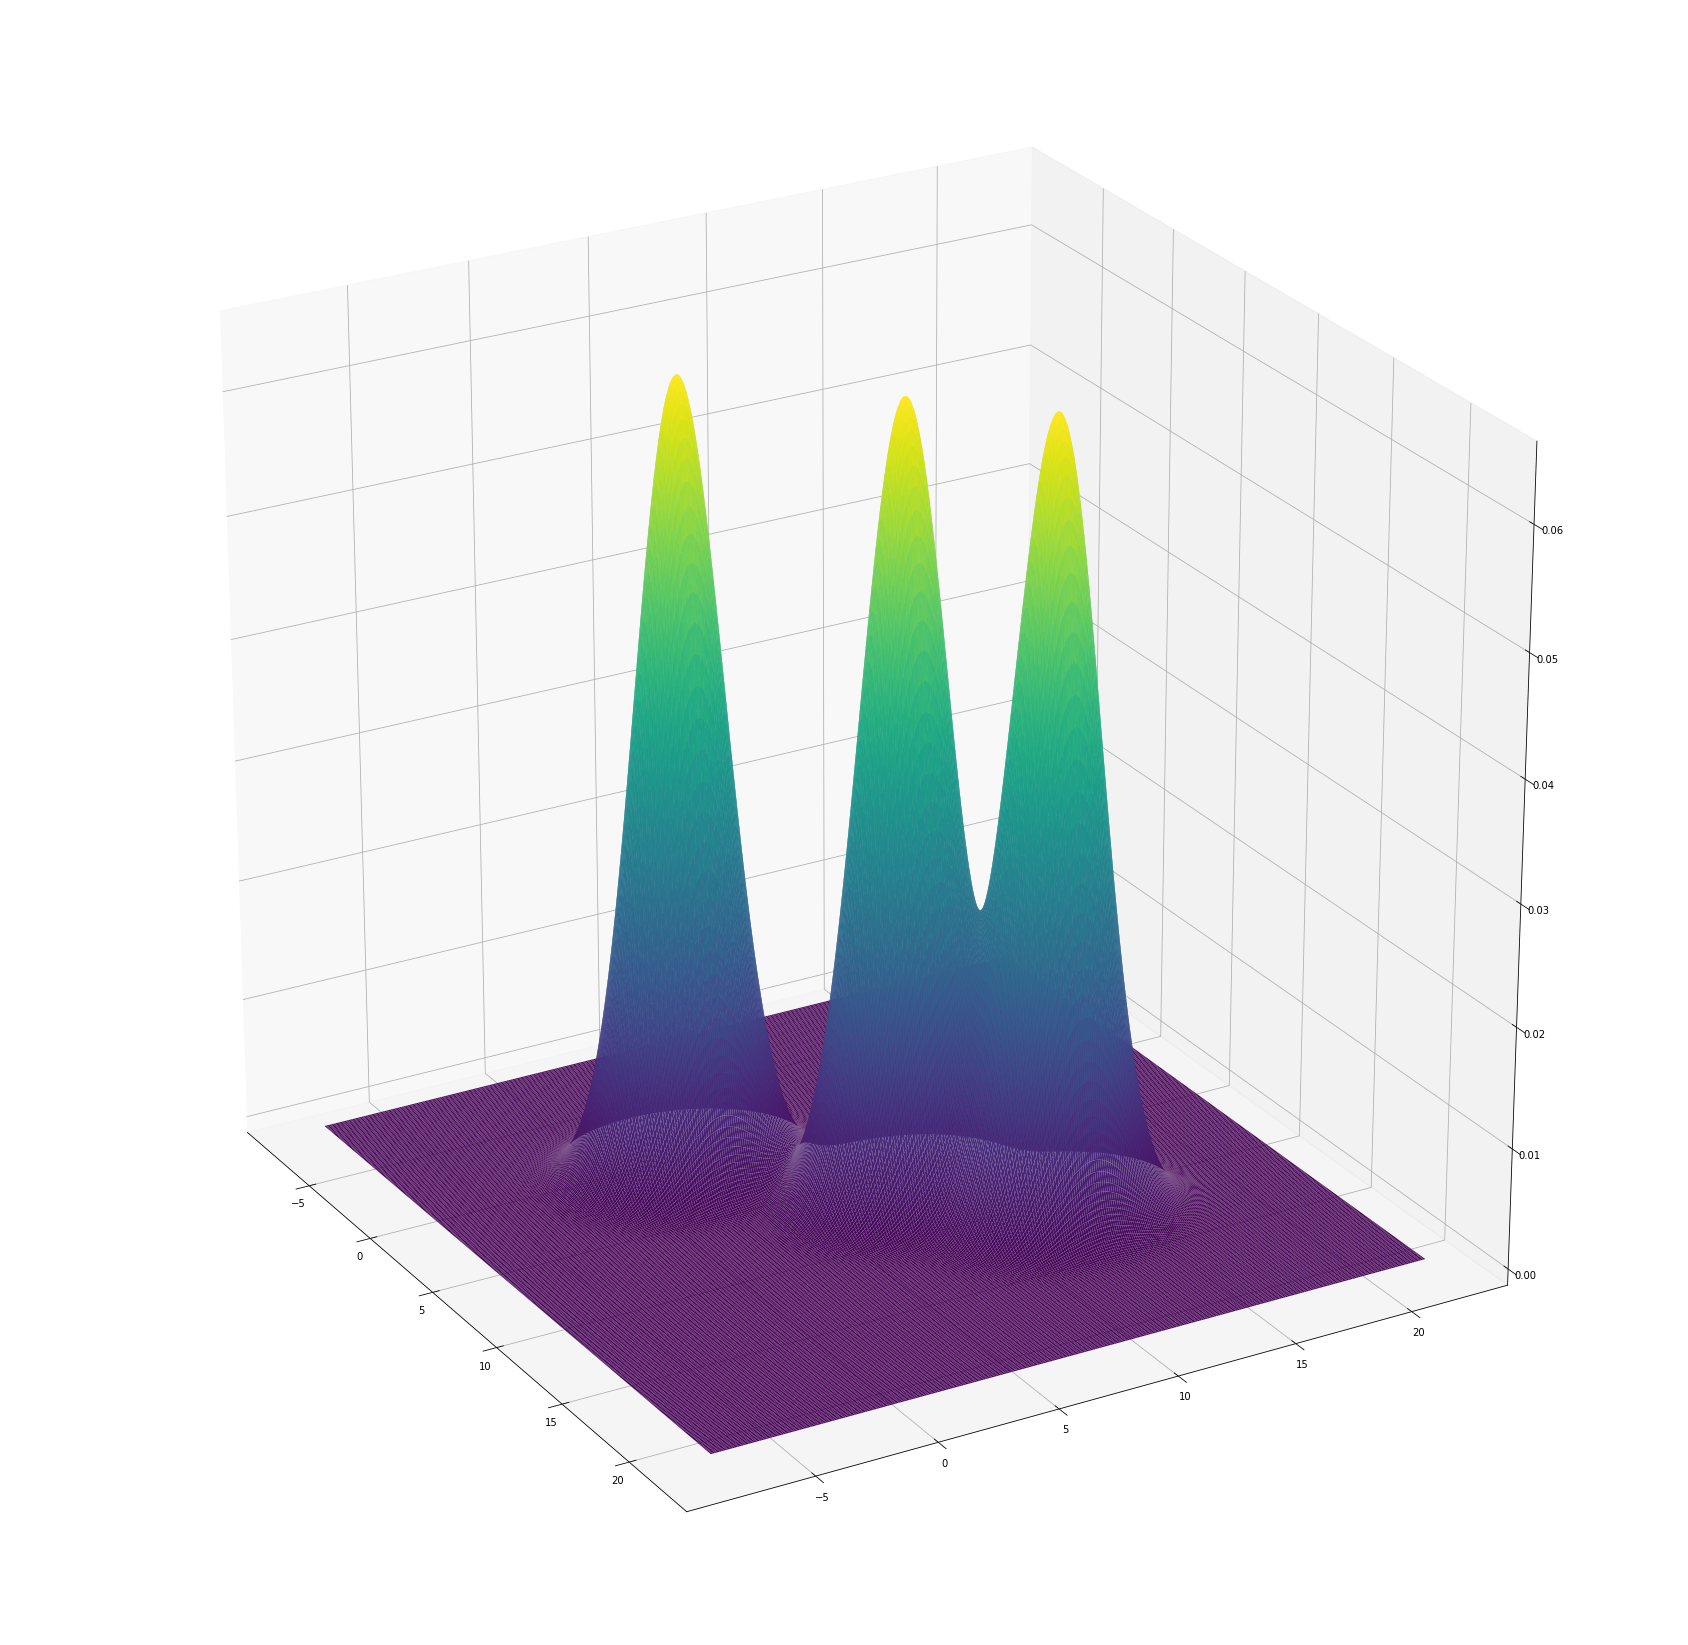

(1000000, 2)
Density estimation using rectangular window


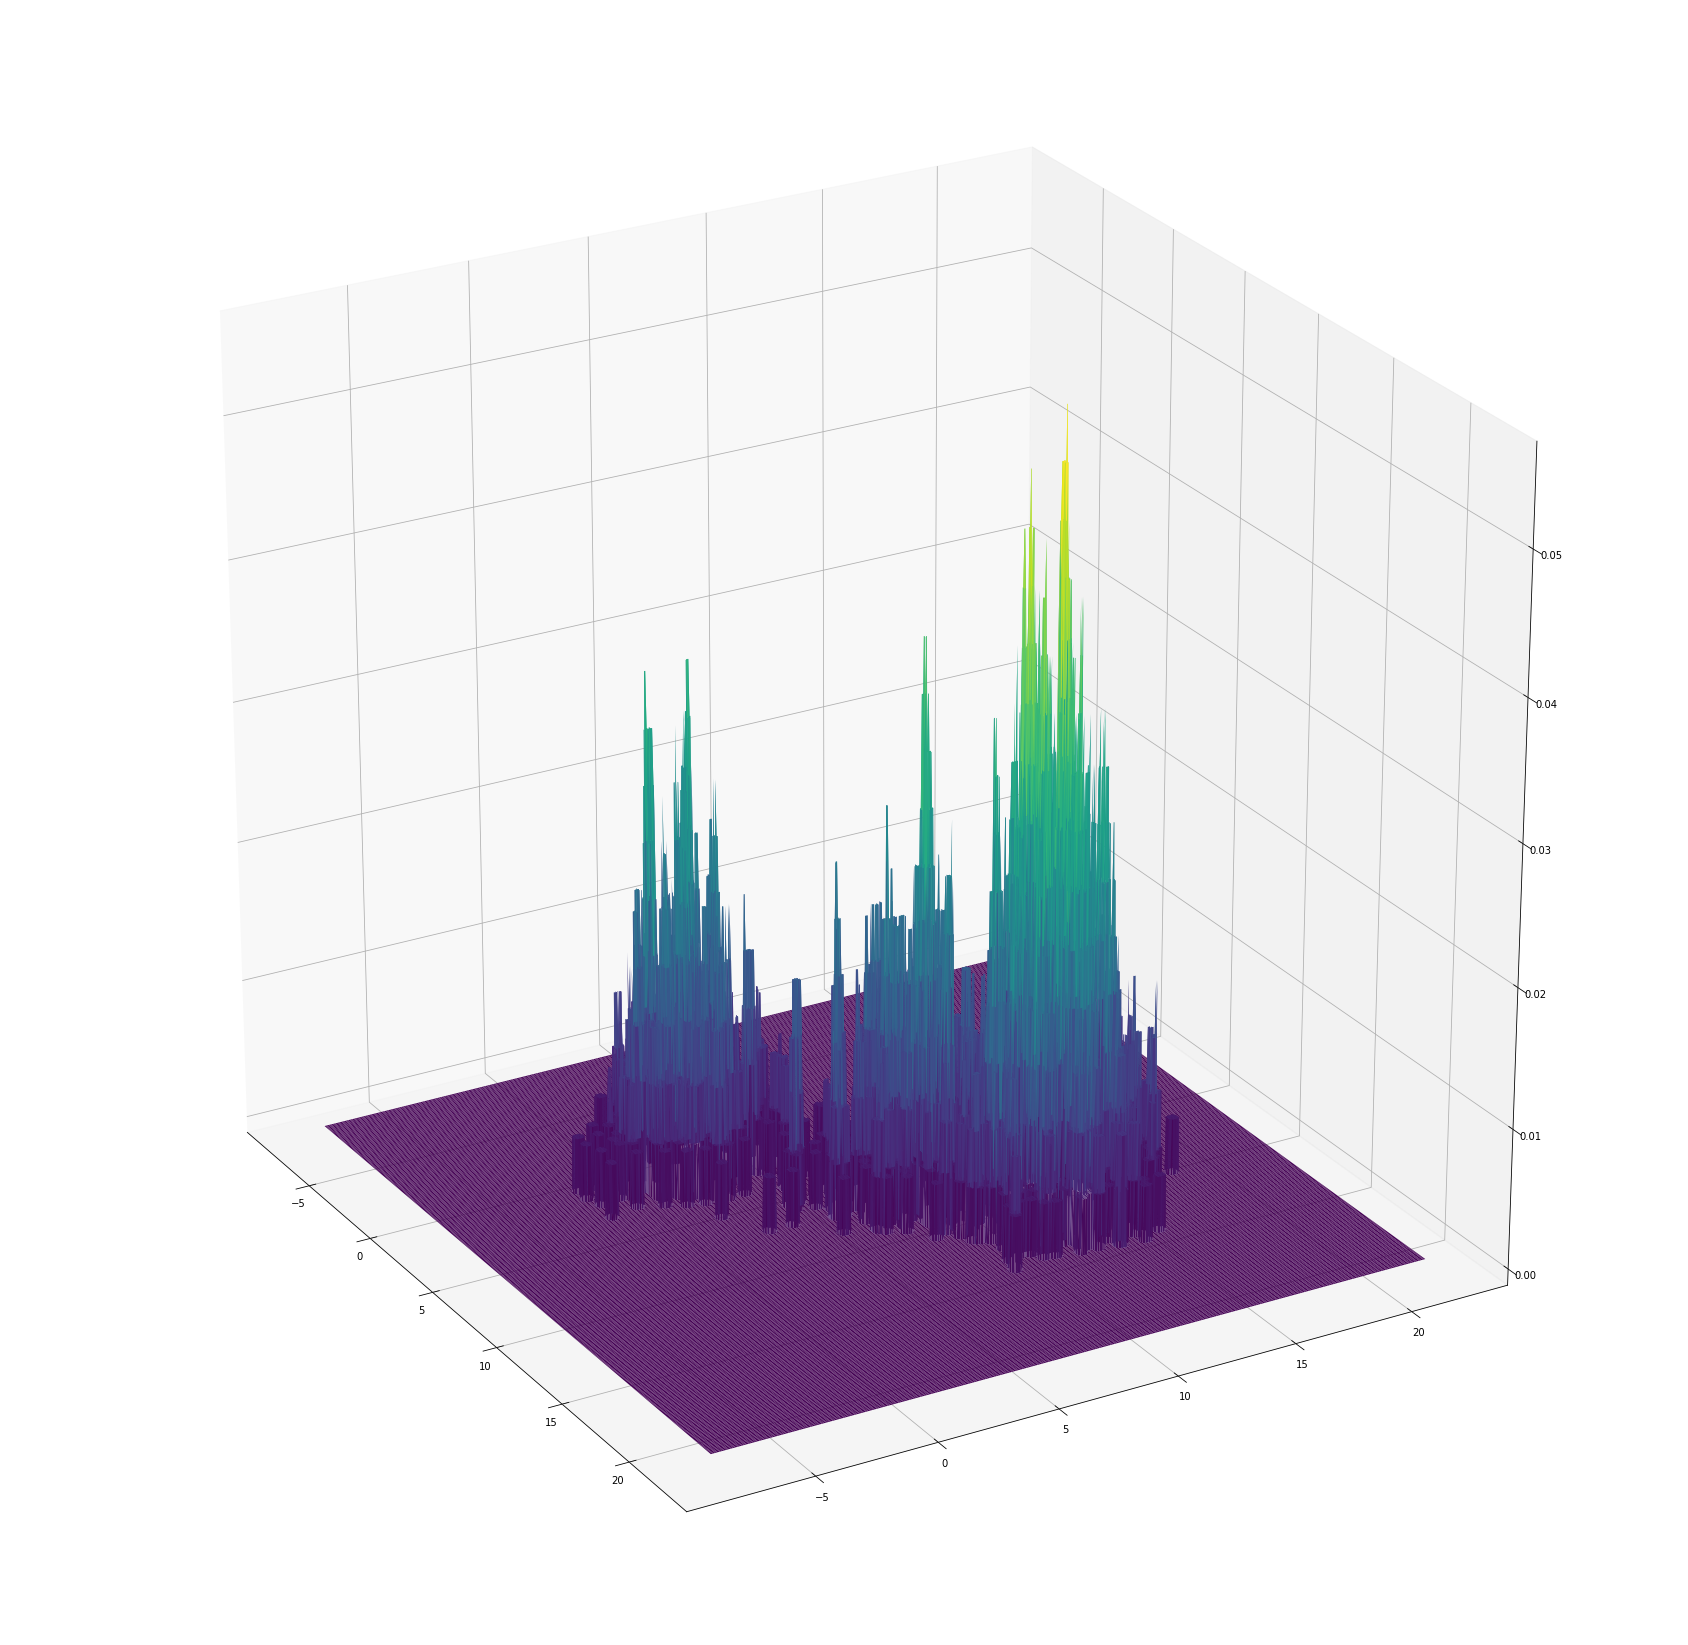

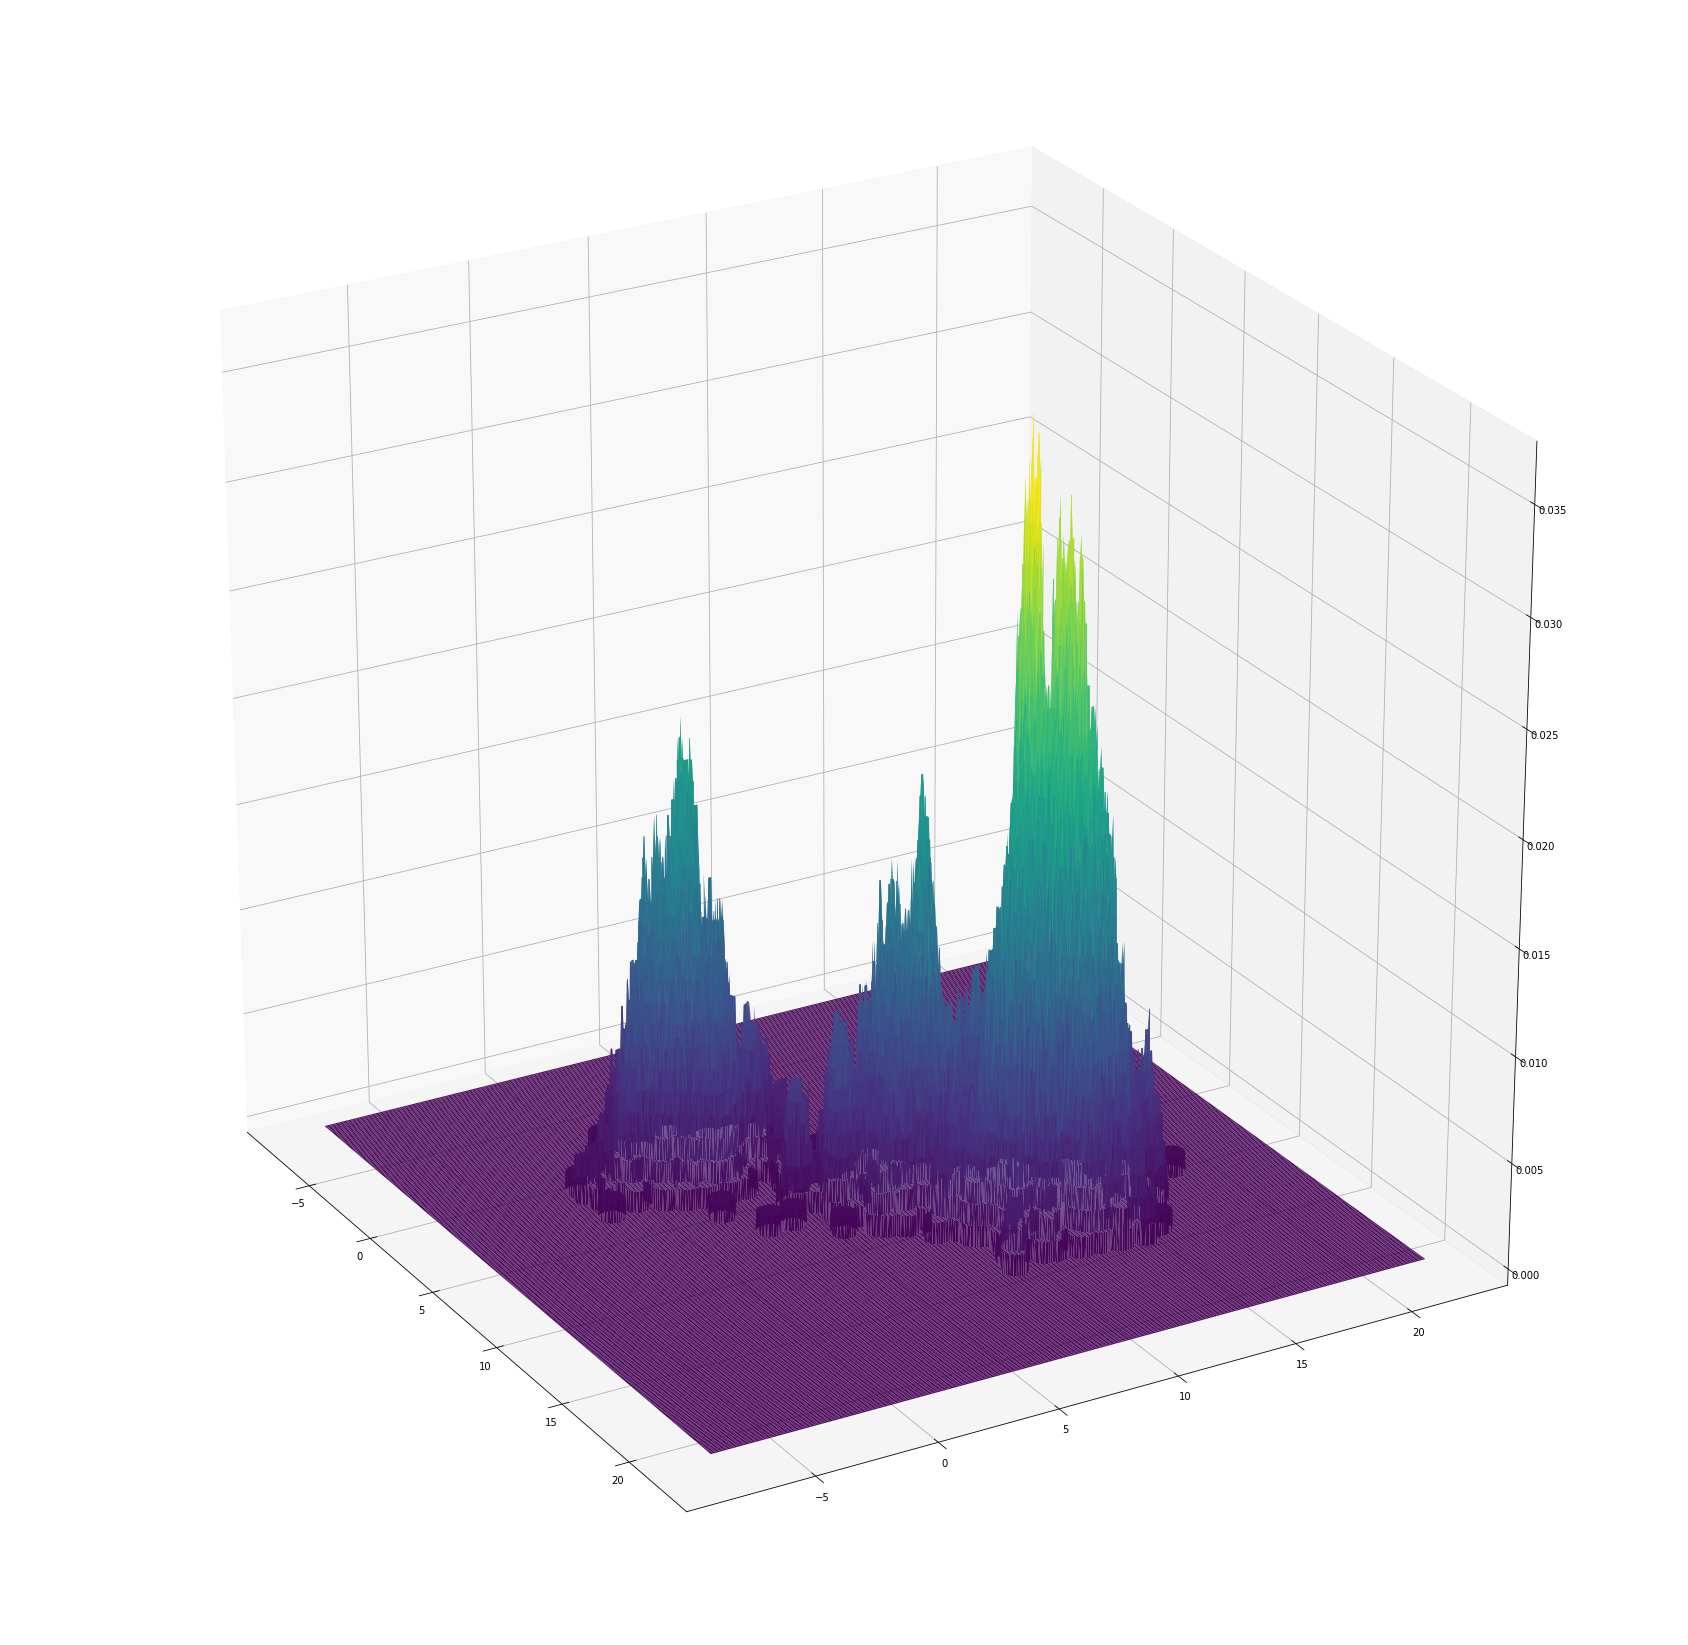

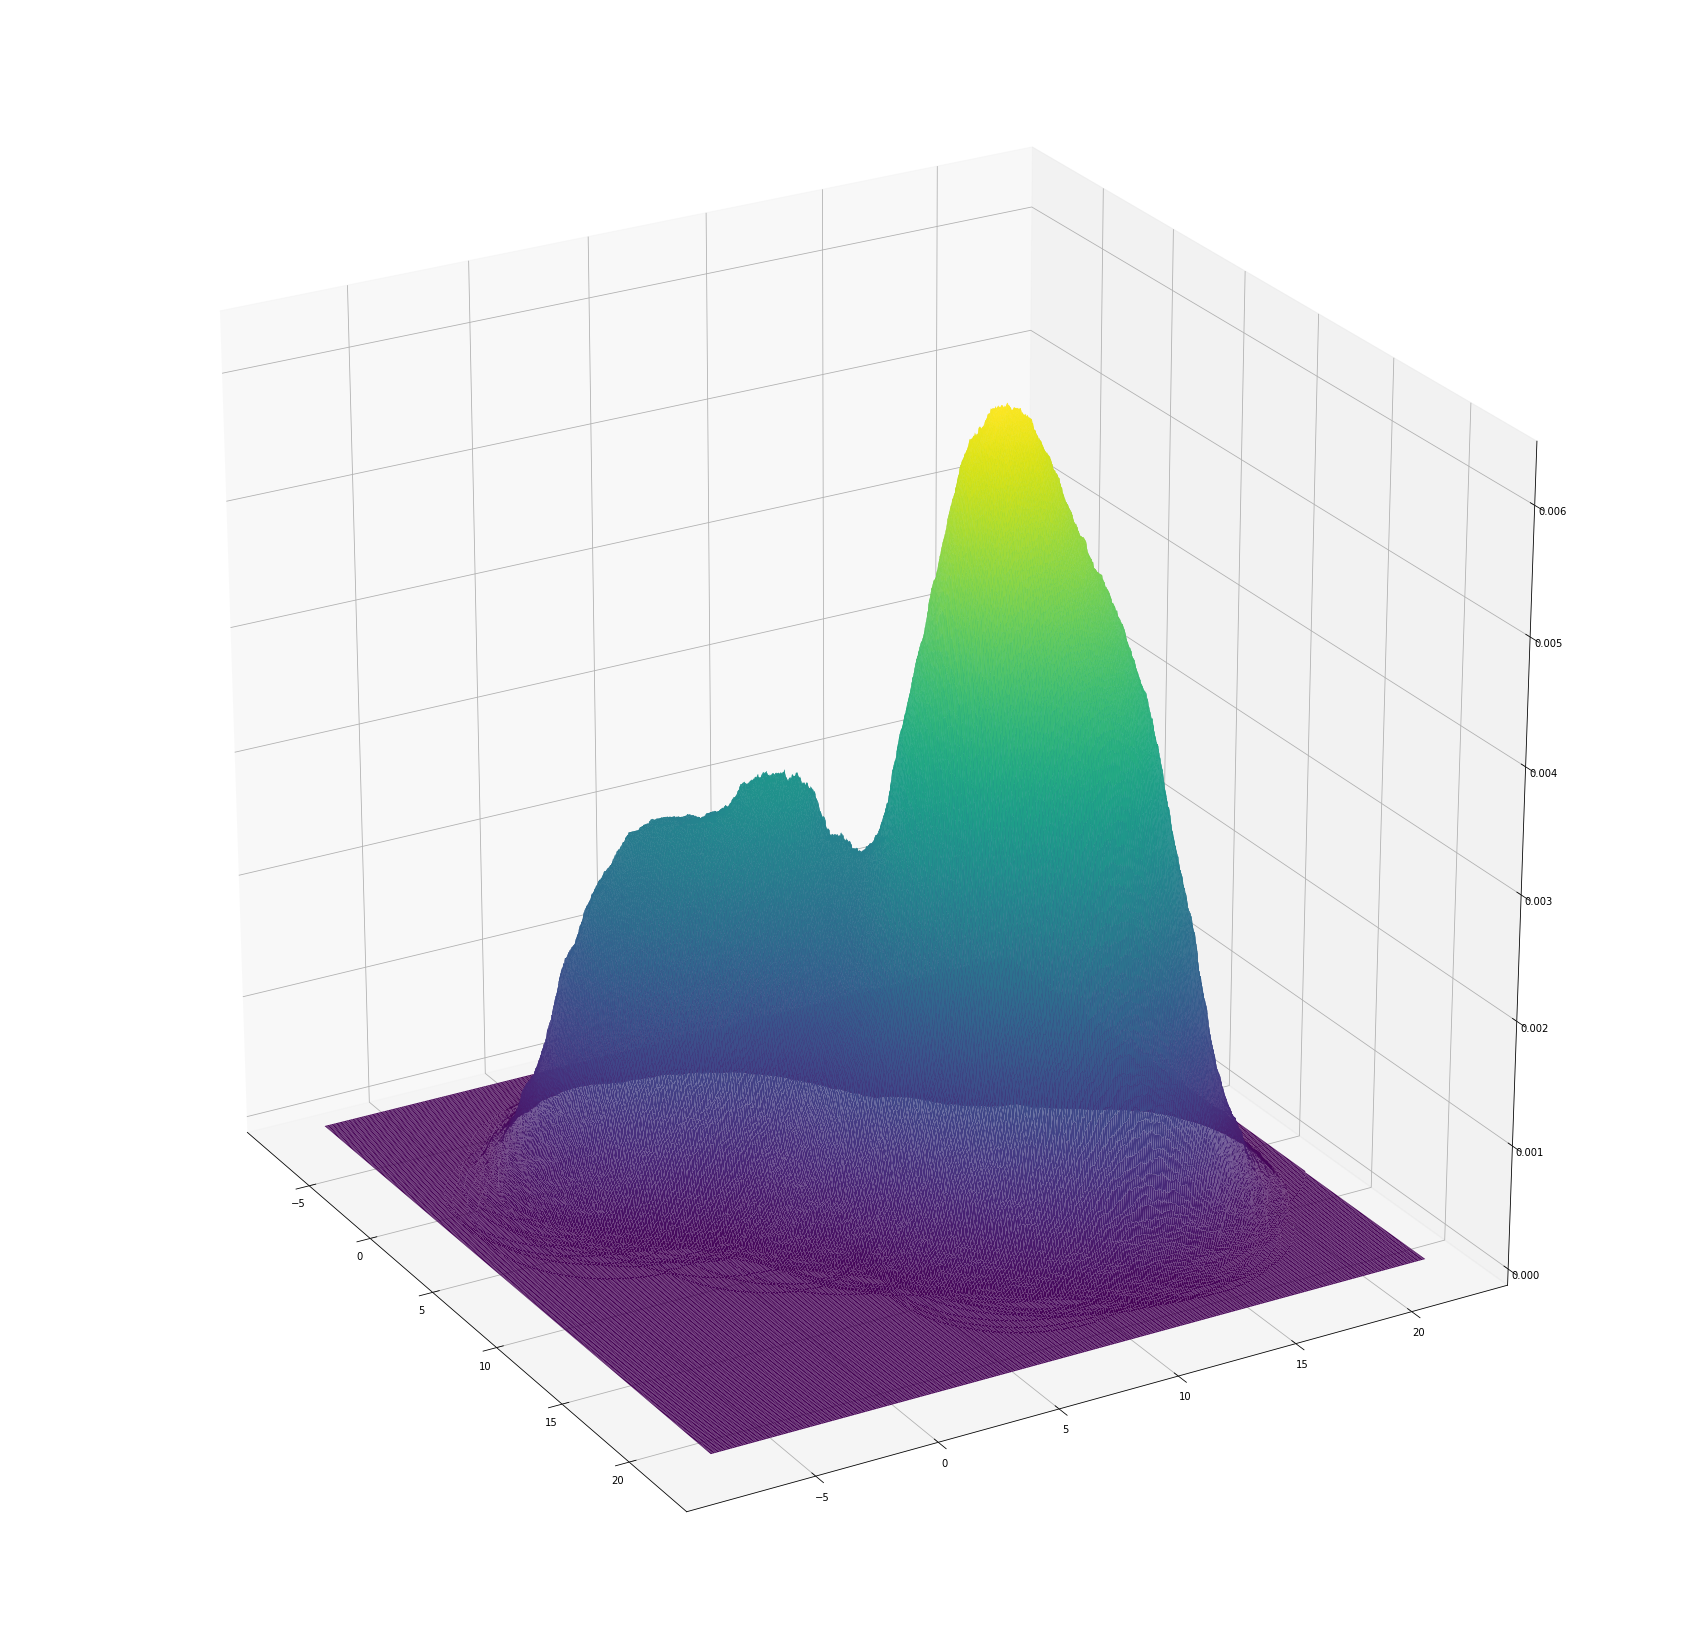

Density estimation using Gaussian as Kernel window


In [ ]:
K =3     # Number of mixture components in GMM 
N = 1000 # Number of samples to be drawn from each mixture of mulitvariate Gaussian to construct the mixture density 
iterations=15
d=2     #dimenion of the data
mean=np.zeros((K,d))
  
covariance=[]


#"""Below code is to generate the mean vector and covariance matrix for the mixture components"""
#mean[0,:]= 0
# covariance_temp= np.ones((d,d))*5
# covariance.append(covariance_temp) #np.linspace(3,6, num=K)
    
# samples_temp=np.random.multivariate_normal(mean[0,:],covariance_temp)
# samples=np.array(samples_temp)
mean=np.array([[2,2],[8,8],[12,12]])
covariance_temp=[[2,0],[0,3]]

for k in range(K):
#    mean[k,:]= np.array(mean[k,:])  # -20+40*np.array()#np.random.rand(1,d)
#     covariance_temp= dataset.make_spd_matrix(d)
#     covariacne_temp=10+5*np.abs(covariance_temp)
    covariance.append(covariance_temp) #np.linspace(3,6, num=K)

true_covar=covariance
lambdas   = [0.3,0.2,0.5]

samples_lst=np.random.multivariate_normal(mean[1,:],covariance[1])
samples_lst=np.reshape(samples_lst,(1,d))
for n in range(N-1):
    mix_no=np.random.choice(3,p=lambdas)
    sample= np.random.multivariate_normal(mean[mix_no,:],covariance[mix_no])
    sample=np.reshape(sample,(1,d))
    samples_lst=np.append(samples_lst,sample,axis=0)

true_covar=covariance
# samples=np.array(samples)
# samples=np.reshape(samples,((int((K+1)*K*N*0.5),d)))

N=1000
samples_test=np.zeros((N,d))
x= np.linspace(np.min(mean)-10,np.max(mean)+10,N)
y= np.linspace(np.min(mean)-10,np.max(mean)+10,N)

samples_test=np.array([x,y])
print(np.shape(samples_test))
samples_test=samples_test.T
X, Y = np.meshgrid(x,y)
#print(samples_test.shape)
pos = np.empty(X.shape + (2,)) 
pos[:, :, 0] = X
pos[:, :, 1] = Y    #pos contains the points at which we estimate the density for plotting

Z = multivariate_normal.pdf(pos, mean[0,:], covariance[0])
for k in range(K-1):
  Z =Z+ multivariate_normal.pdf(pos, mean[k+1,:], covariance[k+1])


# Create a surface plot and projected filled contour plot under it.
fig = plt.figure(figsize=(30,30))
ax = fig.gca(projection='3d')

ax.plot_surface(X, Y, Z, rstride=3, cstride=3, linewidth=1,cmap=cm.viridis)
ax.view_init(25,-30)
plt.show()



#dens_est=np.zeros((pos.shape[0]*pos.shape[1],1))
pos=np.reshape(pos,(pos.shape[0]*pos.shape[1],pos.shape[2]))
print(pos.shape)
h=[0.5,1,10]
print("Density estimation using rectangular window")
for width in h:
  dens_est=np.zeros((pos.shape[0],1))

  for i in range(len(pos)):
      dens_est[i]=rectangular(pos[i],samples_lst,width)

  size_n=int(np.sqrt(dens_est.shape[0]))

  dens_est=np.reshape(dens_est,(size_n,size_n))

  fig = plt.figure(figsize=(30,30))
  ax = fig.gca(projection='3d')

  ax.plot_surface(X, Y, dens_est, rstride=3, cstride=3, linewidth=1,cmap=cm.viridis)
  ax.view_init(25,-30)
  plt.show()

print("Density estimation using Gaussian as Kernel window")
for width in h:
  dens_est=np.zeros((pos.shape[0],1))

  for i in range(len(pos)):
      dens_est[i]=gaussian(pos[i],samples_lst,width)

  dens_est=np.reshape(dens_est,(dens_est.shape[0],dens_est[0]))

  fig = plt.figure(figsize=(30,30))
  ax = fig.gca(projection='3d')

  ax.plot_surface(X, Y, dens_est, rstride=3, cstride=3, linewidth=1,cmap=cm.viridis)
  ax.view_init(25,-30)
  plt.show()



### GMM Estimation using Kernel density estimation with kernel function as Gaussian

(2, 1000)


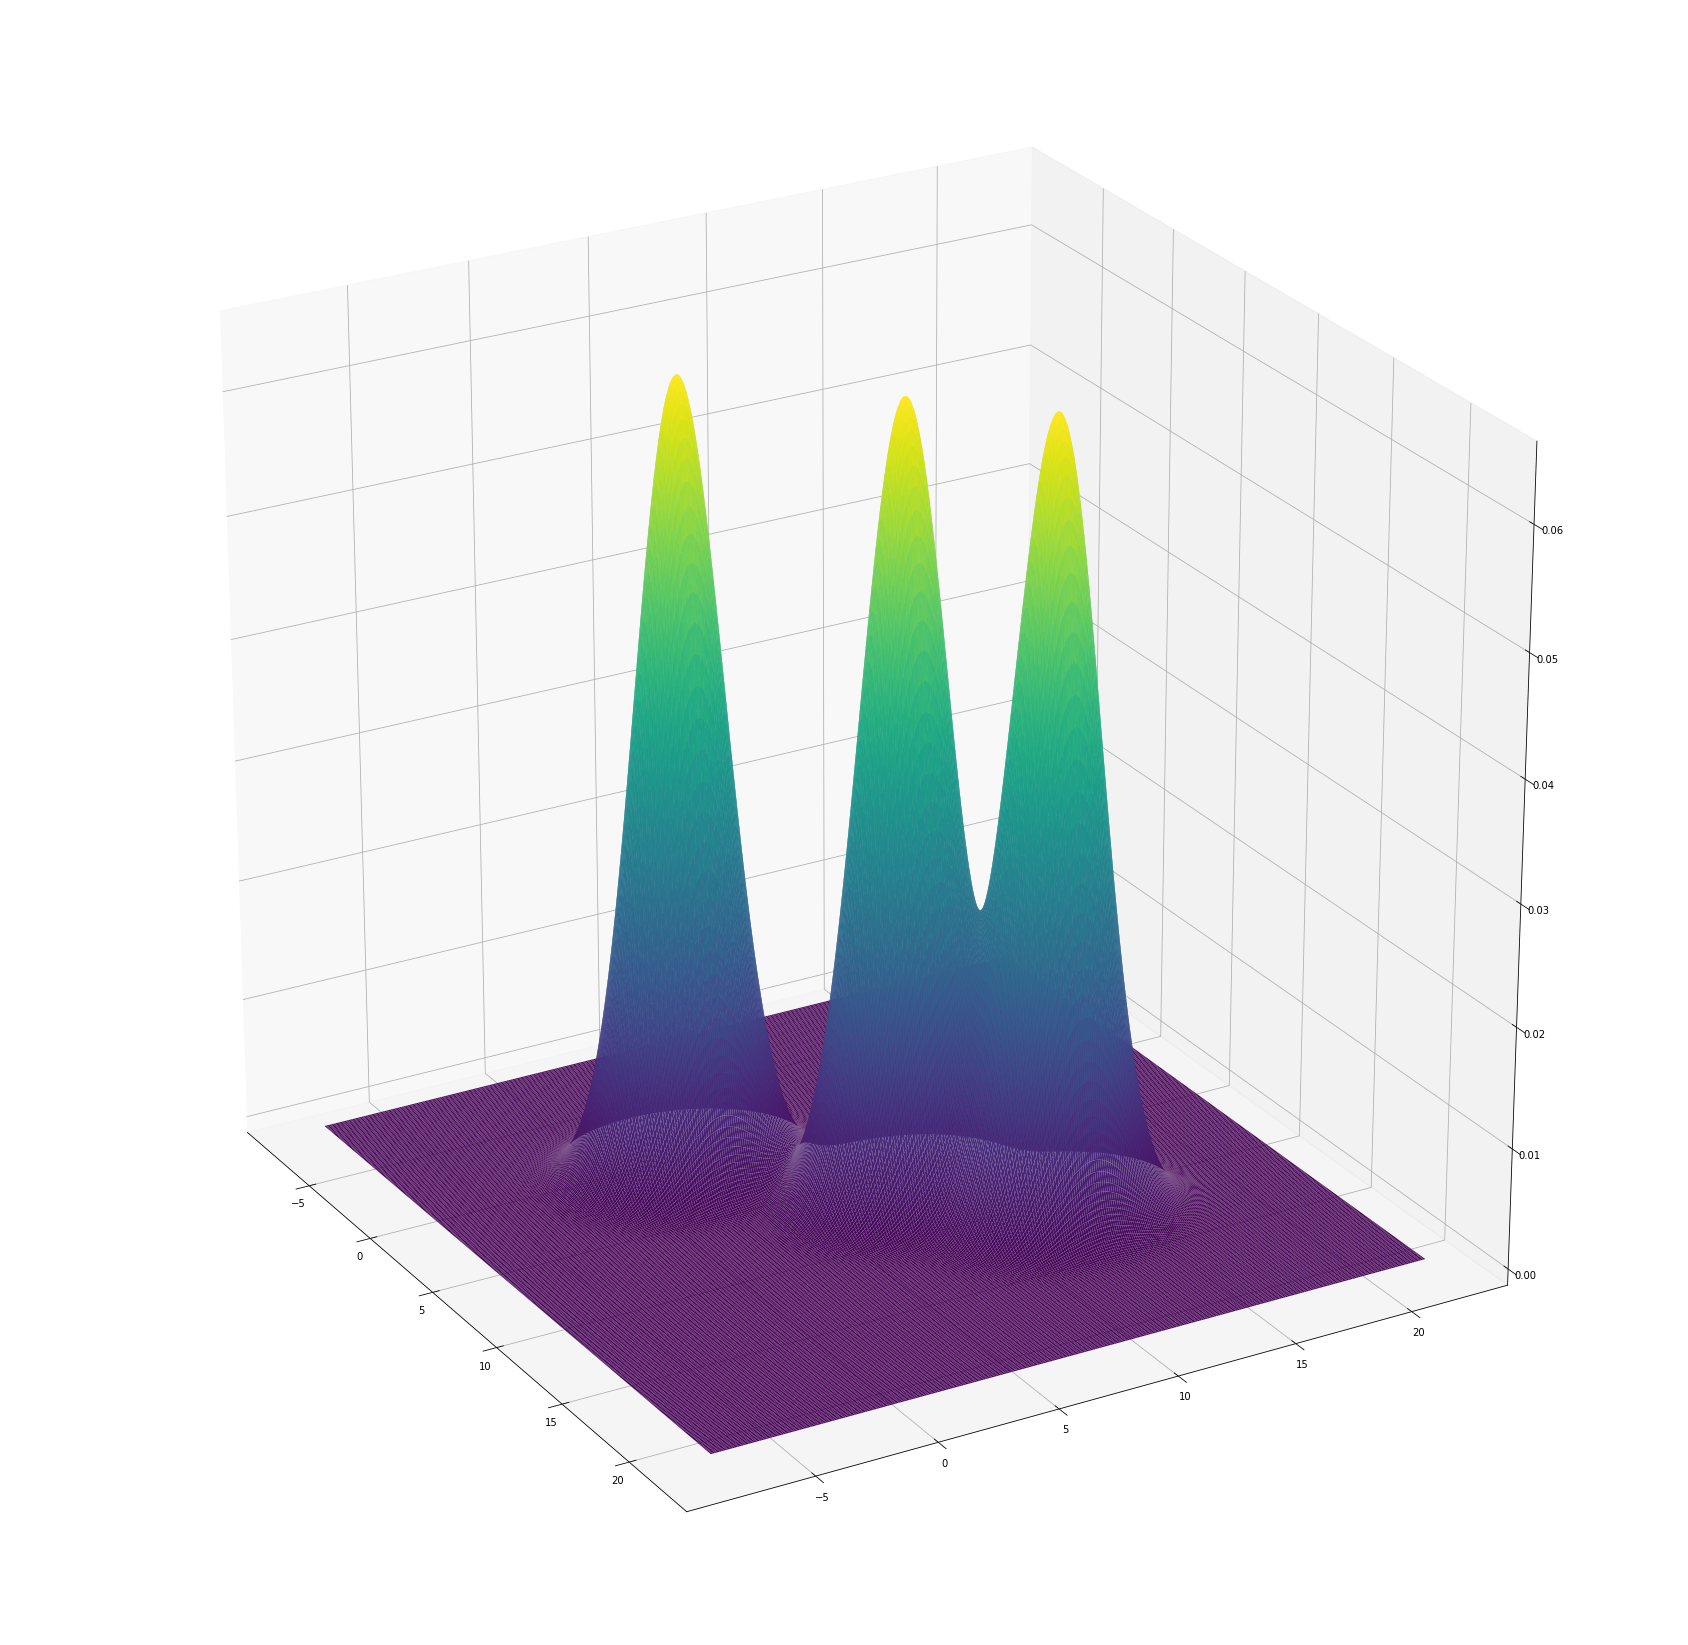

(1000000, 2)
Density estimation using Gaussian as Kernel window


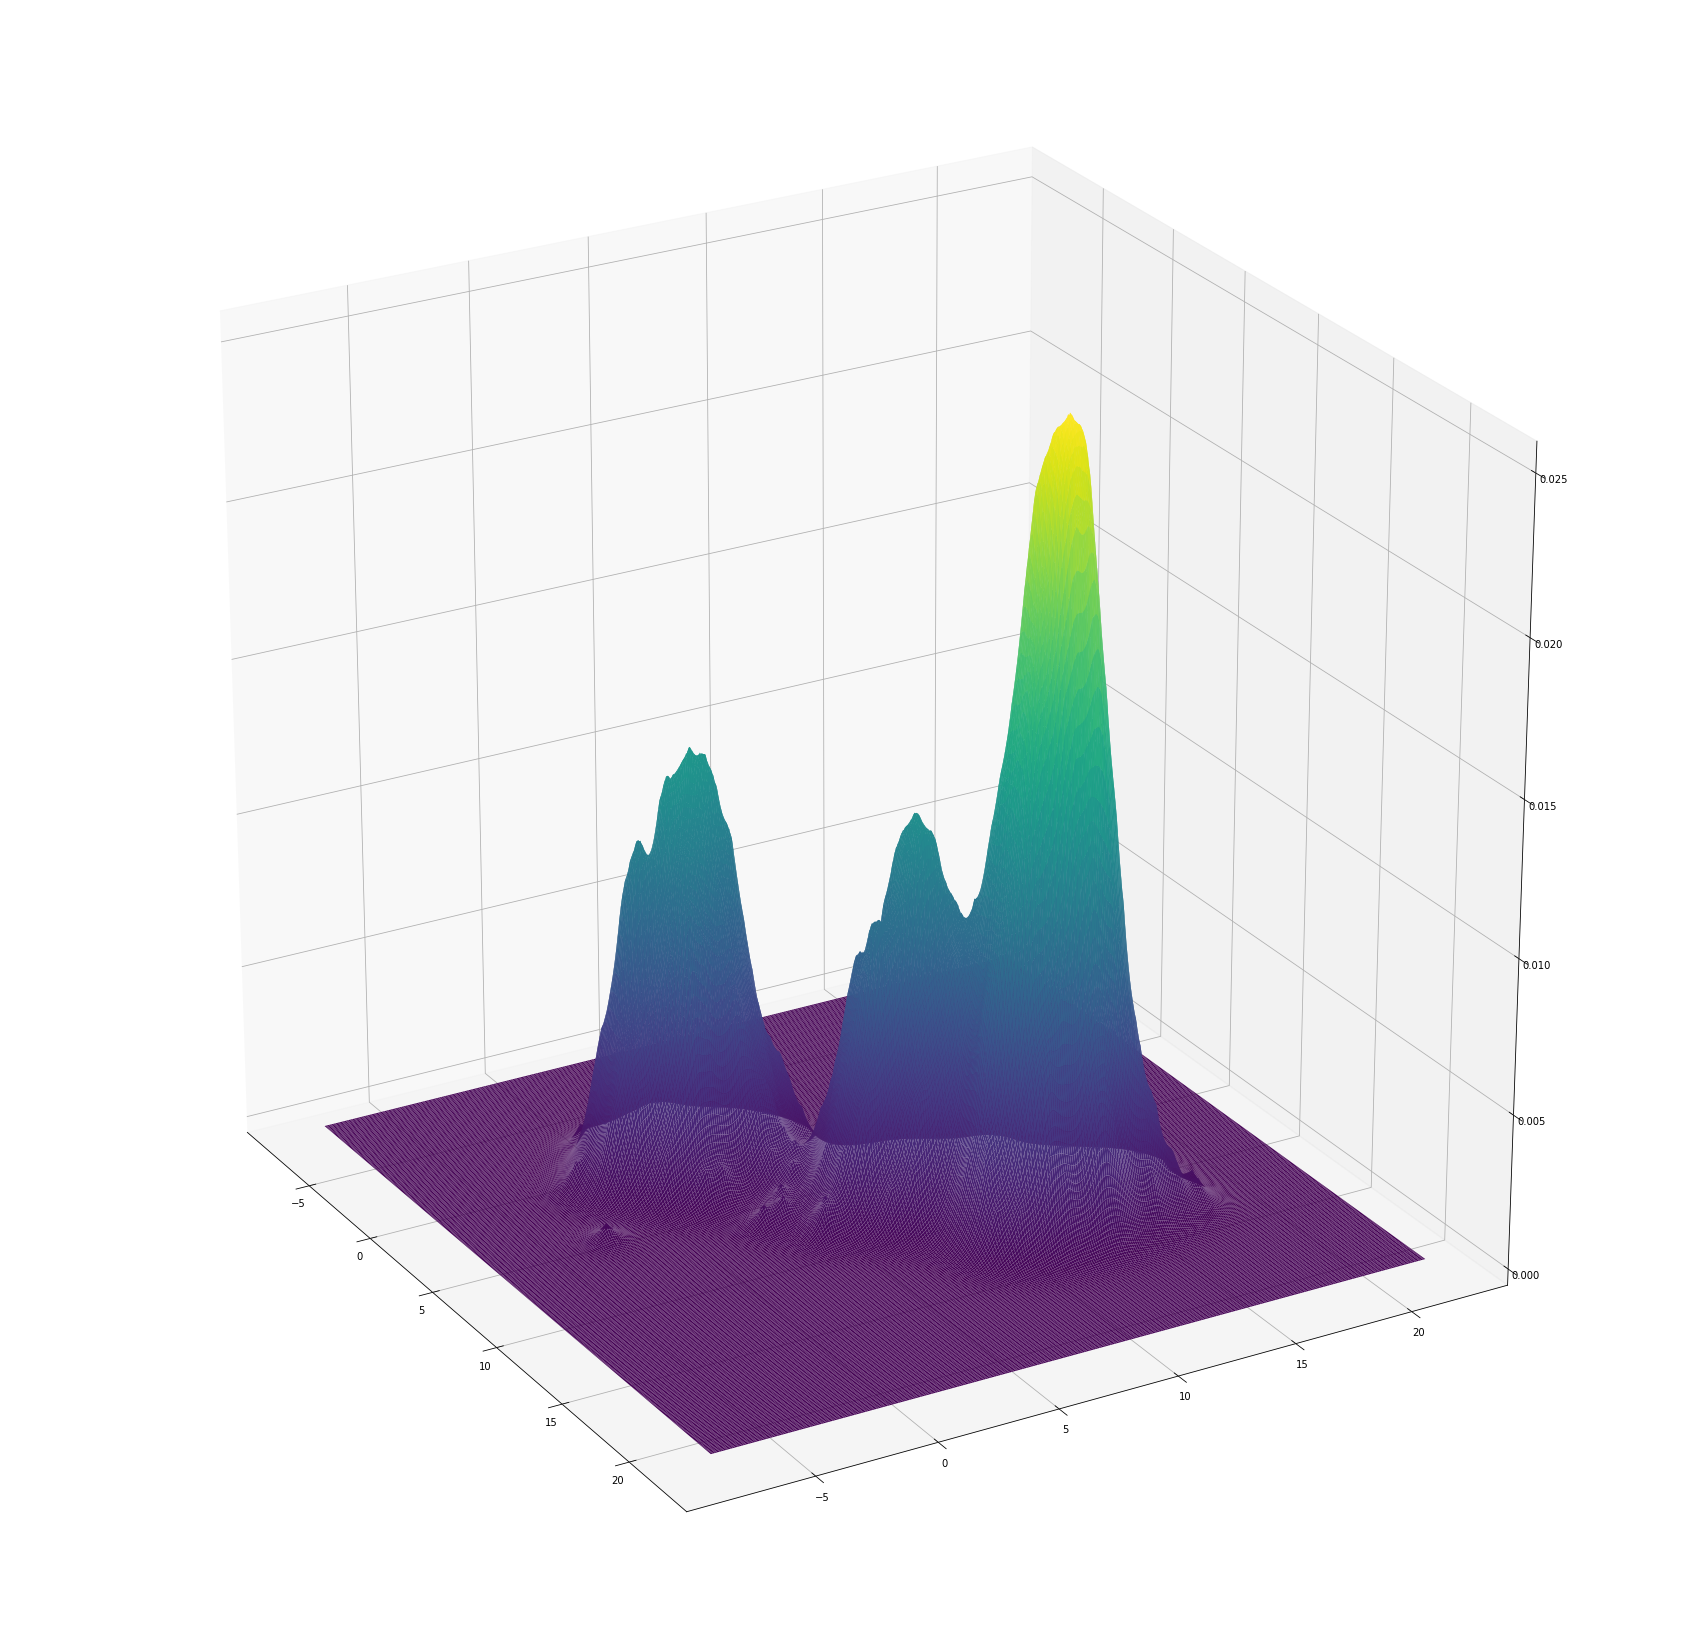

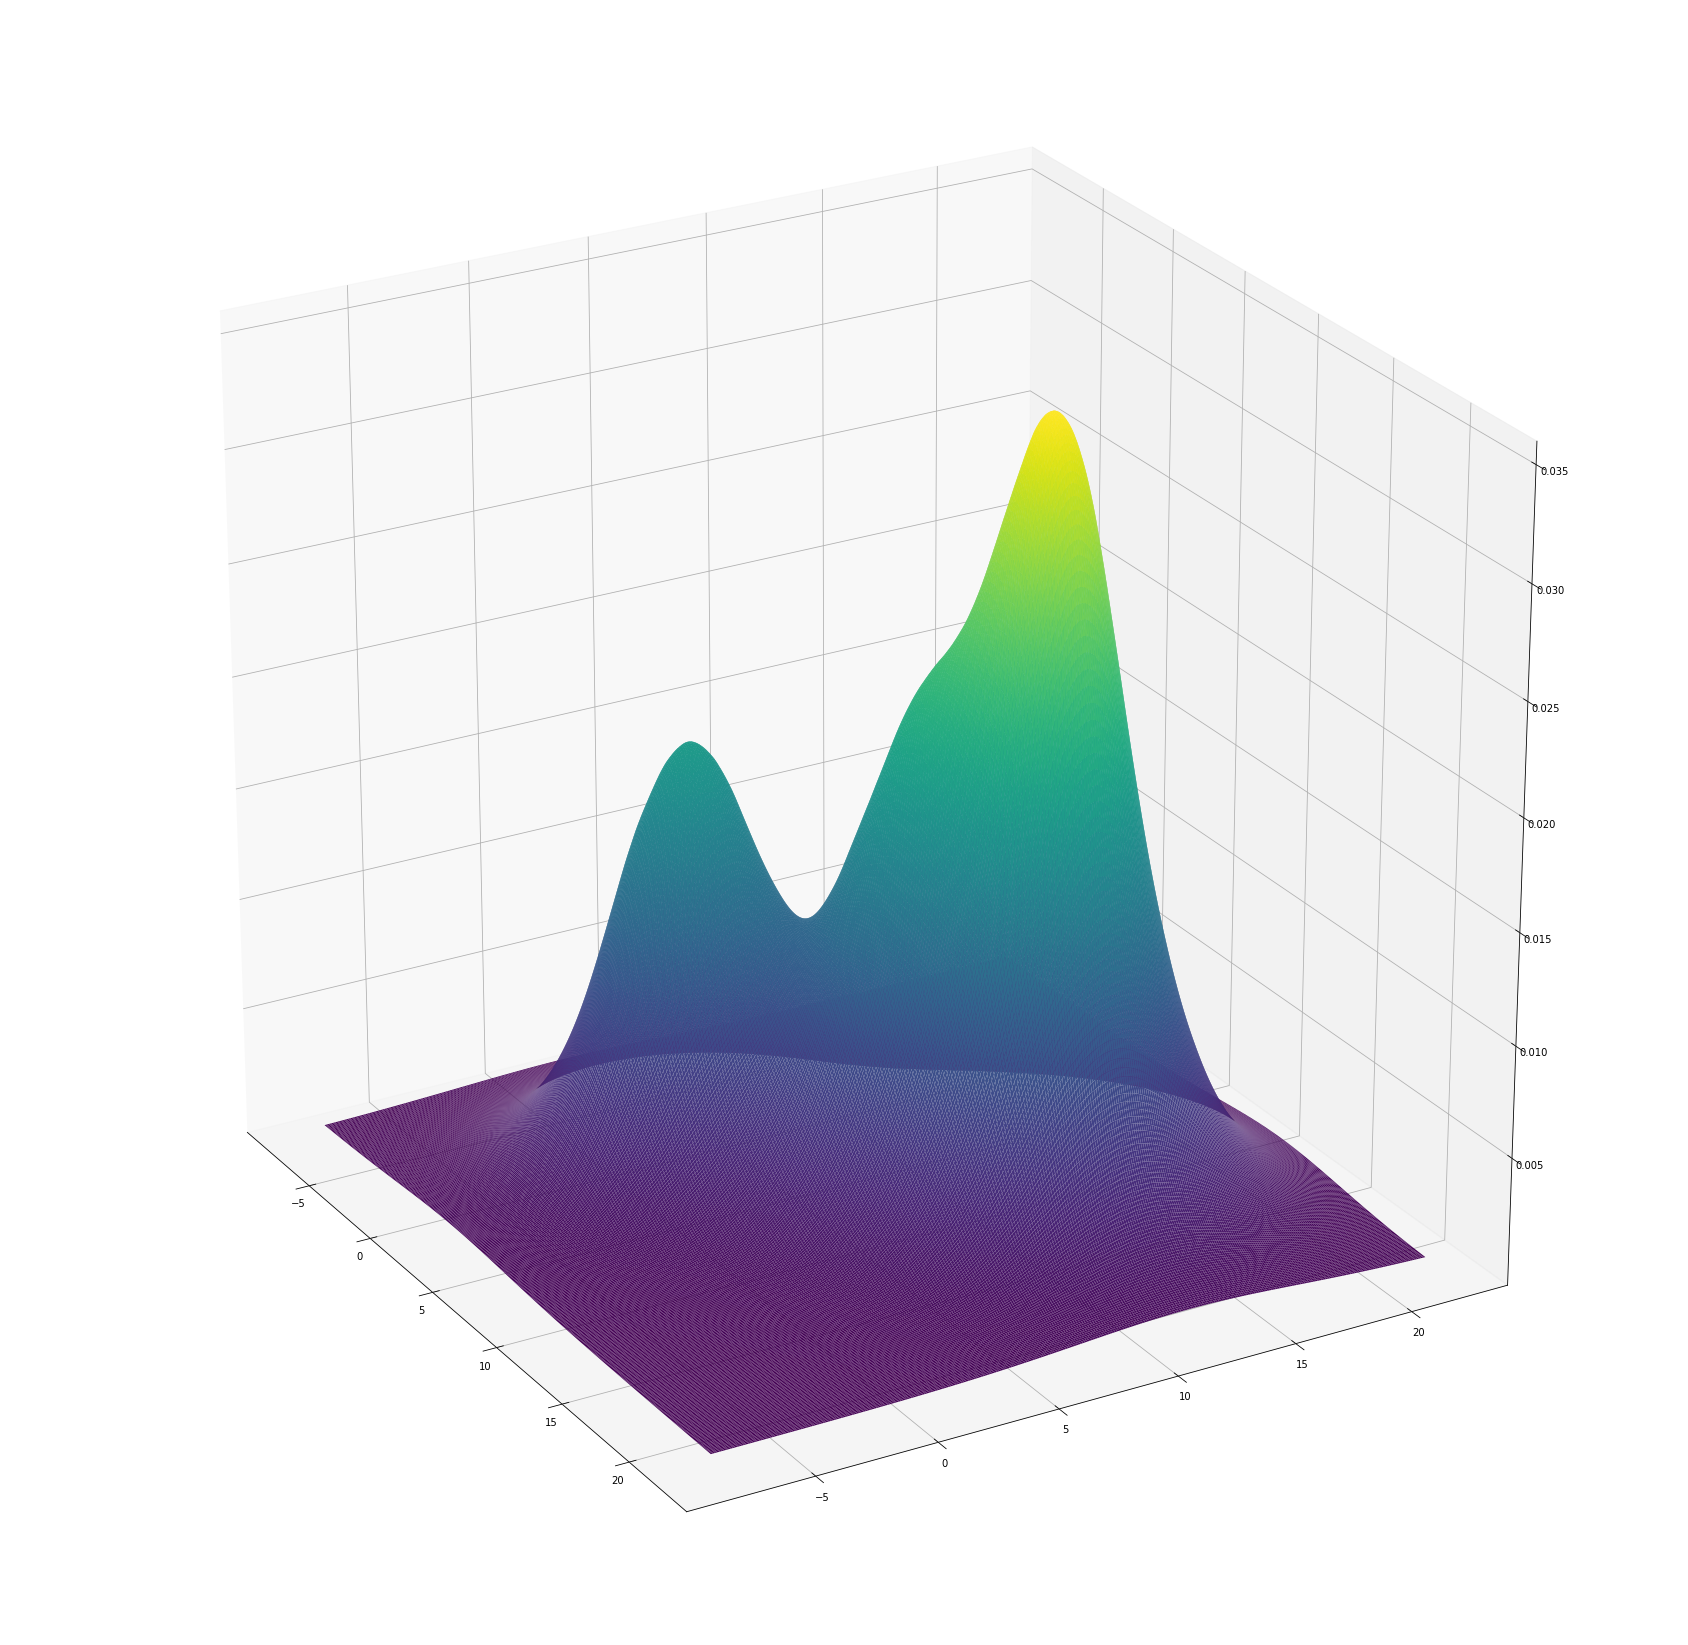

In [ ]:
K =3     # Number of mixture components in GMM 
N = 1000 # Number of samples to be drawn from each mixture of mulitvariate Gaussian to construct the mixture density 
iterations=15
d=2     #dimenion of the data
mean=np.zeros((K,d))
  
covariance=[]


#"""Below code is to generate the mean vector and covariance matrix for the mixture components"""
#mean[0,:]= 0
# covariance_temp= np.ones((d,d))*5
# covariance.append(covariance_temp) #np.linspace(3,6, num=K)
    
# samples_temp=np.random.multivariate_normal(mean[0,:],covariance_temp)
# samples=np.array(samples_temp)
mean=np.array([[2,2],[8,8],[12,12]])
covariance_temp=[[2,0],[0,3]]

for k in range(K):
#    mean[k,:]= np.array(mean[k,:])  # -20+40*np.array()#np.random.rand(1,d)
#     covariance_temp= dataset.make_spd_matrix(d)
#     covariacne_temp=10+5*np.abs(covariance_temp)
    covariance.append(covariance_temp) #np.linspace(3,6, num=K)

true_covar=covariance
lambdas   = [0.3,0.2,0.5]

samples_lst=np.random.multivariate_normal(mean[1,:],covariance[1])
samples_lst=np.reshape(samples_lst,(1,d))
for n in range(N-1):
    mix_no=np.random.choice(3,p=lambdas)
    sample= np.random.multivariate_normal(mean[mix_no,:],covariance[mix_no])
    sample=np.reshape(sample,(1,d))
    samples_lst=np.append(samples_lst,sample,axis=0)

true_covar=covariance
# samples=np.array(samples)
# samples=np.reshape(samples,((int((K+1)*K*N*0.5),d)))

N=1000
samples_test=np.zeros((N,d))
x= np.linspace(np.min(mean)-10,np.max(mean)+10,N)
y= np.linspace(np.min(mean)-10,np.max(mean)+10,N)

samples_test=np.array([x,y])
print(np.shape(samples_test))
samples_test=samples_test.T
X, Y = np.meshgrid(x,y)
#print(samples_test.shape)
pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X
pos[:, :, 1] = Y

Z = multivariate_normal.pdf(pos, mean[0,:], covariance[0])
for k in range(K-1):
  Z =Z+ multivariate_normal.pdf(pos, mean[k+1,:], covariance[k+1])


# Create a surface plot and projected filled contour plot under it.
fig = plt.figure(figsize=(30,30))
ax = fig.gca(projection='3d')

ax.plot_surface(X, Y, Z, rstride=3, cstride=3, linewidth=1,cmap=cm.viridis)
ax.view_init(25,-30)
plt.show()
# #cset = ax.contourf(X, Y, Z, zdir='z', offset=-0.15)
# plt.show()
# # fig = plt.figure(figsize=(10,10))
# # ax = fig.gca(projection='3d')

# #plt.hist(samples_test,bins=50)


# # for row in samples:
# #     ax.scatter(row[0], row[1], color="r", s=5, marker='^')

# # for row in samples_test:
# #     ax.scatter(row[0], row[1], color="k", s=5)


#dens_est=np.zeros((pos.shape[0]*pos.shape[1],1))
pos=np.reshape(pos,(pos.shape[0]*pos.shape[1],pos.shape[2]))
print(pos.shape)
h=[0.5,1,10]

print("Density estimation using Gaussian as Kernel window")
for width in h:
  dens_est=np.zeros((pos.shape[0],1))

  for i in range(len(pos)):
      dens_est[i]=gaussian(pos[i],samples_lst,width)

  size_n=int(np.sqrt(dens_est.shape[0]))

  dens_est=np.reshape(dens_est,(size_n,size_n))
  fig = plt.figure(figsize=(30,30))
  ax = fig.gca(projection='3d')

  ax.plot_surface(X, Y, dens_est, rstride=3, cstride=3, linewidth=1,cmap=cm.viridis)
  ax.view_init(25,-30)
  plt.show()
#   #print(f"At {sample} the estimated density is {dens_est[i]}")
# print(dens_est)
# plt.show()
# plt.plot(samples_test,dens_est)
# #Create grid and multivariate normal
# # x = np.linspace(np.min(),np.max(samples[:,0]),1200)
# # y = np.linspace(np.min(samples[:,1]),np.max(),1200)
# X, Y = np.meshgrid(samples_test[:,0],samples[:,1])
# print(np.shape(X))
# fig=plt.figure(figsize=(15,15))
# #for k in range(1):
#     #rv = multivariate_normal(mean[k,:],covariance[k])
# #Make a 3D plot
# # %matplotlib qt
# ax = fig.gca(projection='3d')
# ax.plot_surface(X, Y, dens_est,cmap='viridis',linewidth=0)
# ax.set_xlabel('X axis')
# ax.set_ylabel('Y axis')
# ax.set_zlabel('Z axis')
# plt.show()




In [ ]:
#ignore the below code

# import numpy as np
# import matplotlib.pyplot as plt
# from matplotlib import cm
# from mpl_toolkits.mplot3d import Axes3D

# # Our 2-dimensional distribution will be over variables X and Y
# N = 400
# X = np.linspace(-10, 30, N)
# Y = np.linspace(-10, 30, N)
# X, Y = np.meshgrid(X, Y)

# # Mean vector and covariance matrix
# mu =  mean[1,:] 
# Sigma =covariance[1] #np.array([[ 1. , 0], [0,  1.]])

# # Pack X and Y into a single 3-dimensional array
# pos = np.empty(X.shape + (2,))
# pos[:, :, 0] = X
# pos[:, :, 1] = Y

# def multivariate_gaussian(pos, mu, Sigma):
#     """Return the multivariate Gaussian distribution on array pos."""

#     n = mu.shape[0]
#     Sigma_det = np.linalg.det(Sigma)
#     Sigma_inv = np.linalg.inv(Sigma)
#     N = np.sqrt((2*np.pi)**n * Sigma_det)
#     # This einsum call calculates (x-mu)T.Sigma-1.(x-mu) in a vectorized
#     # way across all the input variables.
#     fac = np.einsum('...k,kl,...l->...', pos-mu, Sigma_inv, pos-mu)

#     return np.exp(-fac / 2) / N

# # The distribution on the variables X, Y packed into pos.
# Z = multivariate_normal.pdf(pos, mu, Sigma)

# # plot using subplots
# fig = plt.figure(figsize=(30,30))
# ax1 = fig.add_subplot(2,1,1,projection='3d')

# ax1.plot_surface(X, Y, Z, rstride=3, cstride=3, linewidth=1,
#                 cmap=cm.viridis)
# ax1.view_init(55,-70)
# ax1.set_xticks([])
# ax1.set_yticks([])
# ax1.set_zticks([])
# ax1.set_xlabel(r'$x_1$')
# ax1.set_ylabel(r'$x_2$')

# ax2 = fig.add_subplot(2,1,2,projection='3d')
# ax2.contourf(X, Y, Z, zdir='z', offset=0, cmap=cm.viridis)
# ax2.view_init(90, 270)

# ax2.grid(False)
# ax2.set_xticks([])
# ax2.set_yticks([])
# ax2.set_zticks([])
# ax2.set_xlabel(r'$x_1$')
# ax2.set_ylabel(r'$x_2$')

# plt.show()